In [113]:
## Packages need for data pre-process
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

from scipy import sparse
from collections import Counter

import nltk
from numpy import savetxt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

import itertools

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# For evaluztion (NMI)
from sklearn.metrics.cluster import normalized_mutual_info_score

# Running time
from timeit import default_timer as timer

# Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.pyplot import figure

In [42]:
# Import Dataset
df = pd.read_csv('Twitter_mani.csv')
del df['Unnamed: 0']

In [43]:
# Convert to lowercase and convert to list
data = df.text.str.lower().values.tolist()

# Remove Emails
data = [re.sub('@', '', sent) for sent in data]

# Remove hashtages
data = [re.sub('#', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove url
data = [re.sub(r'http\S+', '', sent) for sent in data]

def preProcessingFcn(tweet, 
    removeNumbers=True, removePunctuation=True):
    
    tweet = re.sub(r"\\n", " ", tweet)
    tweet = re.sub(r"&amp", " ", tweet)

    if removeNumbers==True:
        tweet=  ''.join(i for i in tweet if not i.isdigit())
    if removePunctuation==True:
        tweet = re.sub(r"[,.;@#?!&$]+\ *", " ", tweet)
  
    return tweet

data = [preProcessingFcn(tweet) for tweet in data]

In [44]:
# simple_preprocess() tokenies the text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:3])
print(len(data_words))

[[], ['leave', 'it', 'all', 'on', 'the', 'field', 'umichfootball', 'best', 'rivalry', 'in', 'college', 'football', 'goblue', 'beatosu'], ['there', 'no', 'time', 'to', 'look', 'backwards', 'only', 'ahead', 'hyped', 'to', 'watch', 'the', 'umichfootball', 'squad', 'ball', 'out', 'goblue', 'beatosu']]
12780


In [45]:
# Remove Stop Words
stop_words = stopwords.words('english')

# Define functions for stopwords and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_unigrams = remove_stopwords(data_words)

# Stemming

In [46]:
data = []
for i in data_words_unigrams:
    tweet = ' '.join(i)
    data.append(tweet)

In [47]:
def stemming(tweet, stem=True):
    ps = PorterStemmer()

    if stem==True:
        tweet = ' '.join([ps.stem(word) for word in tweet.split()])
    return tweet

data_stemming = [stemming(tweet) for tweet in data]

In [48]:
data_stemming1 = []
for i in data_stemming:
    alist = i.split()
    data_stemming1.append(alist)
    
data_stemming = data_stemming1

In [49]:
# Count unique words
merged = list(itertools.chain.from_iterable(data_stemming))
print(len(merged))
print(len(set(merged)))

# Identify words that appears at least 20 times
c = Counter(merged)
a = list(Counter({k: c for k, c in c.items() if c >= 20}).keys())

# Select words that appears at least 20 times
for i,value in enumerate(data_stemming):
    data_stemming[i] = [i for i in value if i in a] 
    
# Check
merged = list(itertools.chain.from_iterable(data_stemming))
print(len(set(merged)))

# Get the index of the doc that are deleted
empty_idx = []

for i, value in enumerate(data_stemming):
    if any(value) == False:
        empty_idx.append(i)
len(empty_idx)

# Delete empty elements
data_stemming2 = list(filter(None, data_stemming))
print(len(data_stemming2))

141434
10241
1321
12439


In [50]:
# Create Dictionary
id2word = corpora.Dictionary(data_stemming2)

# Create Corpus
texts = data_stemming2

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# 1. LDA

### LDA number of clusters = 4

In [22]:
lda_model =  gensim.models.ldamodel.LdaModel(passes=10,corpus=corpus,id2word=id2word,num_topics = 4, random_state = 88)
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.022*"storm" + 0.019*"week" + 0.017*"tropic" + 0.017*"across" + 0.014*"thunderstorm" + 0.013*"flood" + 0.012*"heat" + 0.012*"weekend" + 0.011*"state" + 0.011*"weather"


Topic: 1 
Words: 0.027*"health" + 0.021*"care" + 0.018*"plan" + 0.018*"ppfa" + 0.017*"peopl" + 0.012*"parenthood" + 0.012*"get" + 0.012*"need" + 0.011*"abort" + 0.011*"women"


Topic: 2 
Words: 0.055*"goblu" + 0.031*"month" + 0.022*"michigan" + 0.016*"one" + 0.016*"year" + 0.016*"first" + 0.013*"night" + 0.011*"game" + 0.011*"day" + 0.011*"meteor"


Topic: 3 
Words: 0.082*"vegan" + 0.046*"wave" + 0.028*"recip" + 0.023*"summer" + 0.021*"made" + 0.015*"free" + 0.014*"bake" + 0.013*"make" + 0.013*"easi" + 0.012*"tofu"




### Collect true labels

In [23]:
df_new = pd.DataFrame(df.drop(df.index[empty_idx]))
df_new = df_new.reset_index(drop=True)
df_new["tokenize"] = data_stemming2

True_Label = list(df_new["user_id_new"])
len(True_Label)

12439

In [24]:
#Get the topic distribution for the given document, #doc in bow format
df_doc_topic = pd.DataFrame(columns = ['Doc_ID', 'Dominant_Topic', 'Prob_Per_Topic', 'Keywords', 'Doc_Text'])
for i in range(len(corpus)):
  a = lda_model.get_document_topics(corpus[i])
  a.sort(key = lambda x: x[1], reverse=True) #highest prob topic first
  topic_wp = lda_model.show_topic(a[0][0]) #show top 10 words byb default
  keywords = [w for (w,p) in topic_wp]
  row = [i, a[0][0], a[0][1], keywords, df_new['text'][i]]
  df_doc_topic.loc[i] = row

### Evaluation

In [ ]:
# NMI
LDA_NMI = []
for i in range(0,18):
    num_cluster = i+3
    lda_model = gensim.models.ldamodel.LdaModel(passes=10,corpus=corpus,id2word=id2word,num_topics = num_cluster, random_state = 88)
    df_doc_topic = pd.DataFrame(columns = ['Dominant_Topic'])
    for i in range(len(corpus)):
        a = lda_model.get_document_topics(corpus[i])
        a.sort(key = lambda x: x[1], reverse=True) #highest prob topic first
        row = [a[0][0]]
        df_doc_topic.loc[i] = row
    pred_LDA = list(df_doc_topic["Dominant_Topic"])
    NMI = normalized_mutual_info_score(True_Label, pred_LDA)
    LDA_NMI.append(NMI)

LDA_NMI

In [26]:
# Purity
Correct_target = pd.DataFrame(df[["screen_name", "user_id_new"]])
Correct_target = Correct_target.drop(Correct_target.index[empty_idx]).reset_index(drop=True)
df_doc_topic = df_doc_topic.reset_index(drop=True)

In [153]:
# Purity
Correct_target = pd.DataFrame(df[["screen_name", "user_id_new"]])
Correct_target = Correct_target.drop(Correct_target.index[empty_idx]).reset_index(drop=True)
df_doc_topic = df_doc_topic.reset_index(drop=True)

LDA_purity = []
for i in range(0,18):
    num_cluster = i+3
    lda_model = gensim.models.ldamodel.LdaModel(passes=10,corpus=corpus,id2word=id2word,num_topics = num_cluster, random_state = 88)
    df_doc_topic = pd.DataFrame(columns = ['Dominant_Topic'])
    for i in range(len(corpus)):
        a = lda_model.get_document_topics(corpus[i])
        a.sort(key = lambda x: x[1], reverse=True) #highest prob topic first
        row = [a[0][0]]
        df_doc_topic.loc[i] = row
    df_compare = pd.concat([df_doc_topic, Correct_target.reindex(df_doc_topic.index)], axis=1)
    nominator = df_compare.groupby(["Dominant_Topic", "user_id_new"], as_index=False)['screen_name'].count().sort_values('screen_name', ascending=False).drop_duplicates('Dominant_Topic')["screen_name"].sum()
    purity = nominator/len(True_Label)
    LDA_purity.append(purity)

In [154]:
LDA_purity 

[0.7435485167617976,
 0.9490312726103385,
 0.9314253557359916,
 0.8899429214567087,
 0.8379290939786156,
 0.8288447624407107,
 0.8500683334673205,
 0.8453251869121312,
 0.8198408232173005,
 0.8685585658011095,
 0.8773213280810355,
 0.867191896454699,
 0.8141329688881743,
 0.8153388536055953,
 0.7158131682611142,
 0.679556234423989,
 0.6367875231127904,
 0.6382345847736957]

### Running Time

In [29]:
# The running time can also be measured simultaneously with the evaluation (when computing NMI and Purity)
LDA_running = []

for i in range(0,18):
    num_cluster = i+3
    start = timer()
    lda_model = gensim.models.ldamodel.LdaModel(passes=10,corpus=corpus,id2word=id2word,num_topics = num_cluster, random_state = 88)
    end = timer()
    time = end-start
    
    LDA_running.append(time)

In [30]:
LDA_running

[24.541619300000093,
 22.577719400000205,
 20.95631869999943,
 21.261016599999493,
 21.80628969999998,
 22.98331120000057,
 21.160482700000102,
 22.066481699999713,
 21.694230300000527,
 19.81751599999916,
 18.270815500000026,
 18.087509399999362,
 17.463955399999577,
 17.076652200000353,
 17.320095299999593,
 17.406181000000288,
 17.385939900000267,
 16.72735289999946]

# 2. CROINFO

In [51]:
%matplotlib inline
import scipy.io as io
from sklearn.metrics import (adjusted_rand_score as ari,
                             normalized_mutual_info_score as nmi)
from coclust.coclustering import CoclustInfo
from scipy.optimize import linear_sum_assignment as linear_assignment
from coclust.evaluation.external import accuracy
from coclust.visualization import plot_delta_kl, plot_convergence
from sklearn.utils import check_random_state, check_array

C:\Users\jueju\.conda\envs\Python3.7\lib\site-packages\sklearn\utils\linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [52]:
# Import Dataset
sparse_matrix = pd.read_csv('doc_word_matrix_stemmingf.csv')
del sparse_matrix['Unnamed: 0']
b = sparse_matrix.to_numpy()

### Evaluation

In [34]:
# NMI
CROINFO_NMI = []
for i in range(0,18):
    num_cluster = i+3
    model = CoclustInfo(n_row_clusters=num_cluster, n_col_clusters=num_cluster,
                    n_init=4, random_state=88)
    model.fit(b)
    n = list(model.row_labels_)
    NMI = normalized_mutual_info_score(True_Label, n)
    CROINFO_NMI.append(NMI)
    
CROINFO_NMI

[0.7043098381694087,
 0.6790122721336654,
 0.7857821059446214,
 0.7431394332895197,
 0.7111411982219402,
 0.7058730392336214,
 0.6835868815976629,
 0.6478897226216574,
 0.6376926514554008,
 0.6306894019118364,
 0.6160624803396079,
 0.6015075030104314,
 0.588349457219723,
 0.5996390481582456,
 0.5877944928673002,
 0.5783823089706712,
 0.5696578756948969,
 0.5597403009596387]

In [155]:
# Purity
CROINFO_purity = []
for i in range(0,18):
    num_cluster = i+3
    model = CoclustInfo(n_row_clusters=num_cluster, n_col_clusters=num_cluster,
                    n_init=4, random_state=88)
    model.fit(b)
    n = pd.DataFrame(list(model.row_labels_), columns = ["Dominant_Topic"])
    df_compare = pd.concat([n, Correct_target.reindex(df_doc_topic.index)], axis=1)
    nominator = df_compare.groupby(["Dominant_Topic", "user_id_new"], as_index=False)['screen_name'].count().sort_values('screen_name', ascending=False).drop_duplicates('Dominant_Topic')["screen_name"].sum()
    purity = nominator/len(True_Label)
    CROINFO_purity.append(purity)
    
CROINFO_purity

[0.7372779162312083,
 0.8374467400916472,
 0.9457351877160544,
 0.9302998633330654,
 0.9548195192539594,
 0.956748934801833,
 0.9422783181927807,
 0.9369724254361284,
 0.9414743950478335,
 0.9582763887772329,
 0.9487900956668542,
 0.955543050084412,
 0.9548999115684541,
 0.9566685424873382,
 0.955221480826433,
 0.9561861886003699,
 0.9562665809148645,
 0.9518450036176541]

### Running Time

In [36]:
CROINFO_Running = []

for i in range(0,18):
    num_cluster = i+3
    start = timer()
    model = CoclustInfo(n_row_clusters=num_cluster, n_col_clusters=num_cluster,
                    n_init=4, random_state=88)
    model.fit(b)
    end = timer()
    time = end-start
    
    CROINFO_Running.append(time)

CROINFO_Running

[6.832472800000687,
 7.42417949999799,
 7.225789999996778,
 7.350030799992965,
 8.15186180001183,
 7.34670000000915,
 7.6426400000054855,
 7.444389099997352,
 7.949637400000938,
 7.740193699995871,
 8.105400100001134,
 7.899508100003004,
 8.160881699994206,
 7.857870299994829,
 8.25968859999557,
 7.968454999994719,
 8.350172899998142,
 8.143195399999968]

# 3. Spectral 

In [53]:
from collections import defaultdict
import operator
from time import time

import numpy as np

from sklearn.cluster import SpectralCoclustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.cluster import v_measure_score

import warnings
warnings.filterwarnings('ignore')

print(__doc__)

Automatically created module for IPython interactive environment


#### (1) svd_method = "randomized"

In [30]:
# NMI and Running time
Running_Time_spec_svd = []
Spectral_NMI = []
for i in range(0,18):
    num_cluster = i+3
    
    start = timer()
    cocluster = SpectralCoclustering(n_clusters=num_cluster,random_state=88)
    cocluster.fit(b)
    end = timer()
    time = end-start
    Running_Time_spec_svd.append(time)
    
    n = list(cocluster.row_labels_)
    NMI = normalized_mutual_info_score(True_Label, n)
    Spectral_NMI.append(NMI)

Running_Time_spec_svd
Spectral_NMI 

[0.722251429597593,
 0.701141834559195,
 0.7956505060316102,
 0.7807960794060524,
 0.7466001684074673,
 0.7327473794982884,
 0.728243819567653,
 0.7026175872025232,
 0.6992008486932633,
 0.6937864912121978,
 0.6854984911252578,
 0.688185487729377,
 0.6667629447109972,
 0.677228491218182,
 0.6860015237561472,
 0.6725505391702611,
 0.6674108420720182,
 0.6820565033620789]

In [156]:
# Purity
Spectral_purity = []
for i in range(0,18):
    num_cluster = i+3
    cocluster = SpectralCoclustering(n_clusters=num_cluster,random_state=88)
    cocluster.fit(b)
    n = pd.DataFrame(list(cocluster.row_labels_), columns = ["Dominant_Topic"])
    df_compare = pd.concat([n, Correct_target.reindex(df_doc_topic.index)], axis=1)
    nominator = df_compare.groupby(["Dominant_Topic", "user_id_new"], as_index=False)['screen_name'].count().sort_values('screen_name', ascending=False).drop_duplicates('Dominant_Topic')["screen_name"].sum()
    purity = nominator/len(True_Label)
    Spectral_purity.append(purity)

Spectral_purity

[0.7318112388455663,
 0.7427445936168502,
 0.9524077498191172,
 0.9613312967280327,
 0.9307822172200337,
 0.9565077578583487,
 0.9557038347134014,
 0.9245920090039392,
 0.9251547552054024,
 0.9278880938982234,
 0.9548195192539594,
 0.9609293351555591,
 0.9561861886003699,
 0.9561057962858751,
 0.959160704236675,
 0.9489508802958437,
 0.9638234584773696,
 0.9634214969048959]

### (2) svd_method = "arpack"

In [48]:
# NMI and Running time
Running_Time_spec_Arpack = []
Spectral_NMI_1 = []
for i in range(0,18):
    num_cluster = i+3
    
    start = timer()
    cocluster = SpectralCoclustering(n_clusters=num_cluster,random_state=88,svd_method='arpack')
    cocluster.fit(b)
    end = timer()
    time = end-start
    Running_Time_spec_Arpack.append(time)
    
    n = list(cocluster.row_labels_)
    NMI = normalized_mutual_info_score(True_Label, n)
    Spectral_NMI_1.append(NMI)
    
Running_Time_spec_Arpack
Spectral_NMI_1

[0.5149984428031352,
 0.48892347876431197,
 0.688221510940847,
 0.652525193434016,
 0.6404455023158004,
 0.6218557160256566,
 0.7091833751971166,
 0.6985429060581483,
 0.6841317319608405,
 0.6729137477657281,
 0.6645438743873631,
 0.6605229964419306,
 0.6542807897204633,
 0.6452082593411158,
 0.6562729569477319,
 0.6461719501840418,
 0.6428433454278316,
 0.6390632934447738]

In [157]:
# Purity
Spectral_purity_1 = []
for i in range(0,18):
    num_cluster = i+3
    cocluster = SpectralCoclustering(n_clusters=num_cluster,random_state=88,svd_method='arpack')
    cocluster.fit(b)
    n = pd.DataFrame(list(cocluster.row_labels_), columns = ["Dominant_Topic"])
    df_compare = pd.concat([n, Correct_target.reindex(df_doc_topic.index)], axis=1)
    nominator = df_compare.groupby(["Dominant_Topic", "user_id_new"], as_index=False)['screen_name'].count().sort_values('screen_name', ascending=False).drop_duplicates('Dominant_Topic')["screen_name"].sum()
    purity = nominator/len(True_Label)
    Spectral_purity_1.append(purity)
    
Spectral_purity_1

[0.5023715732775946,
 0.5052656965994051,
 0.8757938741056355,
 0.8537663799340783,
 0.8554546185384677,
 0.8559369724254361,
 0.9533724575930541,
 0.957633250261275,
 0.9602058043251065,
 0.9606881582120749,
 0.9577940348902645,
 0.9586783503497066,
 0.9557842270278961,
 0.9582763887772329,
 0.9565881501728435,
 0.959160704236675,
 0.960045019696117,
 0.9566685424873382]

# 4. BBAC
### See BBAC.R for implementation details

In [16]:
BBAC =pd.read_csv("BBAC_results_stemming.csv")
BBAC_results = pd.DataFrame(BBAC.drop(["Unnamed: 0", "x"], axis =1))

col_name = ["r3", "r4", "r5", "r6","r7", "r8","r9","r10", "r11", "r12", "r13","r14", "r15","r16", "r17","r18", "r19","r20"]
BBAC_results.columns = col_name

BBAC_results

,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,r14,r15,r16,r17,r18,r19,r20
0,1,4,2,2,7,1,2,2,11,11,4,9,8,13,7,12,6,14
1,1,4,2,6,1,1,2,5,11,10,4,8,8,13,7,12,5,20
2,1,4,2,2,7,1,2,2,11,10,4,8,8,13,7,12,5,20
3,1,4,2,2,7,1,2,5,11,11,4,8,8,12,7,12,5,20
4,1,4,2,2,1,1,2,2,11,10,4,8,8,13,7,12,5,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12434,3,1,4,3,3,7,3,9,1,9,8,1,3,10,8,14,12,1
12435,3,1,4,5,4,4,9,6,4,5,1,10,15,9,10,6,14,13
12436,3,1,4,3,3,4,9,10,10,9,8,12,9,3,8,6,4,2
12437,3,1,4,3,4,4,9,10,7,3,8,12,9,10,10,6,13,7


### Evaluation

In [19]:
#NMI
BBAC_NMI = []
for i, j in enumerate(col_name):
    num_cluster = i+3
    n = BBAC_results[j]
    NMI = normalized_mutual_info_score(True_Label, n)
    BBAC_NMI.append(NMI)
    
BBAC_NMI

[0.6681889307378849,
 0.5875640906477007,
 0.7707255737462888,
 0.5813804518269956,
 0.7276513790613726,
 0.6985922746544447,
 0.6816101509152742,
 0.6733123798733321,
 0.6533675579393954,
 0.6213844871725758,
 0.6443555541849032,
 0.6142967158313571,
 0.6080992445515759,
 0.5942206908557847,
 0.5857388692818499,
 0.5947840570958952,
 0.5736356374306866,
 0.5718474510009416]

In [158]:
# Purity
BBAC_purity = []
for i, j in enumerate(col_name):
    n = pd.DataFrame(BBAC_results[j])
    df_compare = pd.concat([n, Correct_target.reindex(df_doc_topic.index)], axis=1)
    nominator = df_compare.groupby([j, "user_id_new"], as_index=False)['screen_name'].count().sort_values('screen_name', ascending=False).drop_duplicates(j)["screen_name"].sum()
    purity = nominator/len(True_Label)
    BBAC_purity.append(purity)
    
BBAC_purity

[0.7384034086341346,
 0.7101857062464828,
 0.9470214647479701,
 0.7691132727711231,
 0.9565881501728435,
 0.9415547873623281,
 0.9479057802074121,
 0.9487097033523595,
 0.9470214647479701,
 0.9527293190770962,
 0.9573920733177909,
 0.9454136184580754,
 0.943725379853686,
 0.9428410643942439,
 0.9405900795883914,
 0.9543371653669909,
 0.9484685264088754,
 0.948870487981349]

# 5. DCC
### See DCC.R for implementation details

In [32]:
DCC =pd.read_csv("DCC_results_stemming.csv")
DCC_results = pd.DataFrame(DCC.drop(["Unnamed: 0", "x"], axis =1))

col_name = ["r3", "r4", "r5", "r6","r7", "r8","r9","r10", "r11", "r12", "r13","r14", "r15","r16", "r17","r18", "r19","r20"]
DCC_results.columns = col_name

DCC_results

,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,r14,r15,r16,r17,r18,r19,r20
0,3,2,4,5,6,2,6,4,8,1,5,1,7,16,12,4,11,9
1,3,2,4,5,6,1,4,4,8,6,5,13,7,16,4,12,2,9
2,3,2,4,5,6,1,6,4,8,1,8,1,7,16,13,4,2,9
3,3,2,4,5,6,1,6,3,8,6,8,1,7,16,12,11,2,4
4,3,2,4,5,6,1,6,4,8,12,10,1,15,16,4,11,4,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12434,1,1,5,4,4,4,1,5,7,3,2,12,1,4,16,1,6,12
12435,1,1,5,4,4,1,1,5,11,10,2,6,14,4,4,6,10,1
12436,1,1,5,1,3,6,1,9,7,8,7,12,14,4,10,1,9,11
12437,1,1,5,1,3,6,8,9,6,8,3,6,11,10,10,2,5,19


### Evaluation

In [33]:
#NMI
DCC_NMI = []
for i, j in enumerate(col_name):
    num_cluster = i+3
    n = DCC_results[j]
    NMI = normalized_mutual_info_score(True_Label, n)
    DCC_NMI.append(NMI)
    
DCC_NMI

[0.6227627008769423,
 0.8319376913646778,
 0.7309153980333131,
 0.6808882146132479,
 0.6520134531722497,
 0.6431506653175083,
 0.6120619468416802,
 0.5850595097407274,
 0.5587778097917683,
 0.5570205158428284,
 0.536320510712279,
 0.5312562236121128,
 0.505953515480612,
 0.5243113328627137,
 0.48538021650421764,
 0.4800511865115929,
 0.4501423420728995,
 0.4569850000834366]

In [159]:
# Purity
DCC_purity = []
for i, j in enumerate(col_name):
    n = pd.DataFrame(DCC_results[j])
    df_compare = pd.concat([n, Correct_target.reindex(df_doc_topic.index)], axis=1)
    nominator = df_compare.groupby([j, "user_id_new"], as_index=False)['screen_name'].count().sort_values('screen_name', ascending=False).drop_duplicates(j)["screen_name"].sum()
    purity = nominator/len(True_Label)
    DCC_purity.append(purity)
    
DCC_purity

[0.7367151700297452,
 0.9517646113031594,
 0.9196076855052657,
 0.9168743468124447,
 0.925878286035855,
 0.9388214486695072,
 0.9230645550285392,
 0.919527293190771,
 0.9090762923064555,
 0.920411608650213,
 0.9118096309992765,
 0.9073880537020661,
 0.895007637269877,
 0.9247527936329287,
 0.90015274539754,
 0.8888978213682772,
 0.8601977650936571,
 0.8820644746362247]

# 6. Model-based
### See Model_based.R for implementation details

In [35]:
Model_based_results = pd.read_csv('vx_model_based_stemming.csv')
Model_based_results = pd.DataFrame(Model_based_results.drop(["X", "Unnamed: 0"], axis =1))

col_name = ["r3", "r4", "r5", "r6","r7", "r8","r9", "r10", "r11", "r12", "r13","r14", "r15","r16", "r17","r18", "r19","r20"]
Model_based_results.columns = col_name

Model_based_results

,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,r14,r15,r16,r17,r18,r19,r20
0,0,0,4,3,0,1,2,4,3,10,10,13,13,2,16,14,16,14
1,0,0,3,3,3,5,7,4,3,5,10,13,10,2,15,14,12,14
2,0,3,1,2,3,1,7,8,4,2,4,0,0,3,0,10,14,19
3,2,0,3,0,0,7,0,4,10,3,9,7,4,6,7,12,12,2
4,0,3,3,3,3,5,2,8,3,10,9,1,0,14,10,6,16,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12434,1,2,2,4,1,4,1,0,9,1,12,2,1,15,6,8,4,17
12435,1,2,0,4,1,3,3,2,0,9,8,7,5,6,6,9,7,17
12436,1,2,2,4,1,4,1,0,1,4,12,2,1,11,4,8,4,17
12437,1,2,2,4,1,4,1,0,1,4,12,2,1,11,6,8,4,17


### Evaluation

In [36]:
#NMI
MB_NMI = []
for i, j in enumerate(col_name):
    num_cluster = i+3
    n = Model_based_results[j]
    NMI = normalized_mutual_info_score(True_Label, n)
    MB_NMI.append(NMI)
    
MB_NMI

[0.4583168832250383,
 0.43894692901679055,
 0.32544906740898605,
 0.5071878576929155,
 0.4932914184622104,
 0.4804506121271954,
 0.4920324671596314,
 0.4564451845392707,
 0.31403552312748895,
 0.43721453064723353,
 0.2921036758665151,
 0.2938806010419014,
 0.29923148302506447,
 0.2875372233726535,
 0.26421060209766467,
 0.2839412072733192,
 0.4485616622000316,
 0.2760085149532954]

In [160]:
# Purity
MB_purity = []
for i, j in enumerate(col_name):
    n = pd.DataFrame(Model_based_results[j])
    df_compare = pd.concat([n, Correct_target.reindex(df_doc_topic.index)], axis=1)
    nominator = df_compare.groupby([j, "user_id_new"], as_index=False)['screen_name'].count().sort_values('screen_name', ascending=False).drop_duplicates(j)["screen_name"].sum()
    purity = nominator/len(True_Label)
    MB_purity.append(purity)
    
MB_purity

[0.6177345445775384,
 0.6378326232012219,
 0.5690168019937294,
 0.7359916391992926,
 0.7751426963582282,
 0.7566524640244393,
 0.7743387732132808,
 0.7707211190610178,
 0.6333306535895168,
 0.7568936409679234,
 0.6022992201945494,
 0.5934560656001286,
 0.6195835678109173,
 0.6156443444006753,
 0.5644344400675295,
 0.5994854891872337,
 0.7676662111102178,
 0.5952246965190128]

# 7. Ferg's Method

In [61]:
## packages
import os 
import csv
import numpy as np
from pyclustering.cluster.kmedoids import kmedoids
import pandas as pd
import statsmodels.api as sm # table
from sklearn.decomposition import LatentDirichletAllocation as LDA
import random 

In [62]:
### c = word co-occurrence matrix
## rows=words, columns=words
## c_ij=number of times words i and j appear in the same tweet
c = b.T.dot(b)

w = b
n = w.shape[0]
v = w.shape[1]

In [ ]:
### s = tweet distance matrix
    ## rows=tweets, cols=tweet
    ## s_ij=mean d[words in tweet i & not in j, 
    ##             words in tweet j & not in i]

s = np.zeros([n, n])


for i in range(n):
    for j in range(n):
        if i<=j:
            iWords = np.where(w[i,:]>0)[0]
            jWords = np.where(w[j,:]>0)[0]
            ijIntersect = set(iWords) & set(jWords)
            iWordsUse = [word for word in iWords if word not in ijIntersect]
            jWordsUse = [word for word in jWords if word not in ijIntersect]
            dtweetsij = d[np.ix_(iWordsUse, jWordsUse)]
            entries = dtweetsij.shape[0]*dtweetsij.shape[1]
            if entries !=0:
                ij = np.sum(dtweetsij) / entries
                s[i,j] = ij
                s[j,i] = ij

In [161]:
#s = pd.read_csv("Robyn_tweets_distance.csv", header=None)

In [162]:
Ferg_results = []
for i in range(0,18):
    
    numberTopics = i+3
    kmedoids_instance_tweets = kmedoids(s, range(numberTopics), data_type='distance_matrix')
    kmedoids_instance_tweets.process()
    clusters_tweets = kmedoids_instance_tweets.get_clusters()
    
    medoidCluster = list()
    for i in range(len(True_Label)):
        for clustNum in range(numberTopics):
            if i in clusters_tweets[clustNum]:
                medoidCluster.append(clustNum)
    Ferg_results.append(medoidCluster)

### Evaluation

In [ ]:
#NMI
Ferg_NMI = []

for i in range(0,18):
    n = [i]
    NMI = normalized_mutual_info_score(True_Label, n)
    Ferg_NMI.append(NMI)

Ferg_NMI

In [163]:
# Purity
Ferg_purity = []

for i in range(0,18):
    n = pd.DataFrame(Ferg_results[i])
    df_compare = pd.concat([n, Correct_target.reindex(df_doc_topic.index)], axis=1)
    df_compare.columns = ["results", "screen_name","user_id_new"]
    nominator = df_compare.groupby(["results", "user_id_new"], as_index=False)['screen_name'].count().sort_values('screen_name', ascending=False).drop_duplicates("results")["screen_name"].sum()
    purity = nominator/len(True_Label)
    Ferg_purity.append(purity)

Ferg_purity

[0.6527052013827478,
 0.8958115604148243,
 0.8932390063509928,
 0.8421898866468366,
 0.8594742342632045,
 0.8384114478655841,
 0.8763566203070986,
 0.8872899750783825,
 0.8736232816142777,
 0.873542889299783,
 0.8734624969852882,
 0.8931586140364981,
 0.8931586140364981,
 0.8666291502532358,
 0.8575448187153308,
 0.8626095345284991,
 0.8983037221641611,
 0.8966958758742665]

### Running Time

In [ ]:
Running_Time = []

for i in range(0,18):
    numberTopics = i+3
    start = timer()
    kmedoids_instance_tweets = kmedoids(s, range(numberTopics), data_type='distance_matrix')
    kmedoids_instance_tweets.process()
    end = timer()
    time = end-start
    
    Running_Time.append(time)

Running_Time 

# Summary and Visualization

In [187]:
# NMI
evaluation_summary_NMI = pd.read_csv('evaluation_summary_NMI_new_stemming.csv')
evaluation_summary_NMI = evaluation_summary_NMI.drop(["Unnamed: 0"], axis = 1) 
evaluation_summary_NMI

,K,LDA,CROINFO,DCC,Model Based,BBAC,Ferg Method,Spectral_randomized,Spectral_arpack
0,3,0.739975,0.704310,0.618672,0.458317,0.668189,0.409773,0.714602,0.488511
1,4,0.830290,0.679012,0.826124,0.438947,0.587564,0.726670,0.699023,0.472867
2,5,0.773391,0.785782,0.734219,0.325449,0.770726,0.713720,0.795279,0.687319
3,6,0.677983,0.743139,0.674763,0.507188,0.581380,0.600645,0.776660,0.649464
4,7,0.578343,0.711141,0.632556,0.493291,0.727651,0.604515,0.737081,0.634199
5,8,0.480322,0.705873,0.635086,0.480451,0.698592,0.553537,0.721737,0.612179
6,9,0.538994,0.683587,0.617728,0.492032,0.681610,0.610422,0.718749,0.696230
7,10,0.520122,0.647890,0.581689,0.456445,0.673312,0.612004,0.689971,0.680501
8,11,0.475920,0.637693,0.564538,0.314036,0.653368,0.609637,0.685968,0.663776
9,12,0.514666,0.630689,0.549884,0.437215,0.621384,0.590844,0.679484,0.648163


In [188]:
figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('tab10')
 
# multiple line plot
#color_palette = ["red","blue","orange","green","purple"]
num = 0
for column in evaluation_summary_NMI.drop('K', axis=1):
    #color_n = color_palette[num]
    num+=1
    plt.plot(evaluation_summary_NMI['K'], evaluation_summary_NMI[column], marker='', color=palette(num), linewidth=1, alpha=1, label=column)
 # Add legend
    plt.legend(loc=2, ncol=2)
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
 # Add titles
    plt.title("NMI of LDA and document co-clustering algorithms for various number of clusters", loc='left', fontsize=15, fontweight=0, color='black')
    plt.xlabel("K (number of clusters)")
    plt.ylabel("NMI")


In [197]:
# Purity
evaluation_summary_purity = pd.read_csv('evaluation_summary_purity_new_stemming.csv')
evaluation_summary_purity = evaluation_summary_purity.drop([ 'Unnamed: 0'], axis = 1) 
evaluation_summary_purity

,K,LDA,CROINFO,DCC,Model Based,BBAC,Ferg Method,Spectral_randomized,Spectral_arpack
0,3,0.743549,0.737278,0.736715,0.617735,0.738403,0.652705,0.731811,0.502372
1,4,0.949031,0.837447,0.951765,0.637833,0.710186,0.895812,0.742745,0.505266
2,5,0.931425,0.945735,0.919608,0.569017,0.947021,0.893239,0.952408,0.875794
3,6,0.889943,0.930300,0.916874,0.735992,0.769113,0.842190,0.961331,0.853766
4,7,0.837929,0.954820,0.925878,0.775143,0.956588,0.859474,0.930782,0.855455
5,8,0.828845,0.956749,0.938821,0.756652,0.941555,0.838411,0.956508,0.855937
6,9,0.850068,0.942278,0.923065,0.774339,0.947906,0.876357,0.955704,0.953372
7,10,0.845325,0.936972,0.919527,0.770721,0.948710,0.887290,0.924592,0.957633
8,11,0.819841,0.941474,0.909076,0.633331,0.947021,0.873623,0.925155,0.960206
9,12,0.868559,0.958276,0.920412,0.756894,0.952729,0.873543,0.927888,0.960688


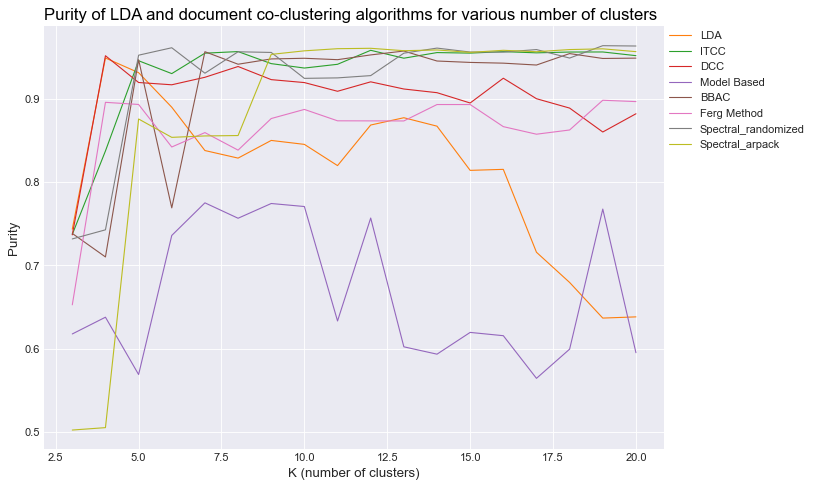

In [198]:
figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('tab10')
 
# multiple line plot
#color_palette = ["red","blue","orange","green","purple"]
num = 0
for column in evaluation_summary_purity.drop('K', axis=1):
    #color_n = color_palette[num]
    num+=1
    plt.plot(evaluation_summary_purity['K'], evaluation_summary_purity[column], marker='', color=palette(num), linewidth=1, alpha=1, label=column)
 # Add legend
    plt.legend(loc=2, ncol=2)
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
 # Add titles
    plt.title("Purity of LDA and document co-clustering algorithms for various number of clusters", loc='left', fontsize=15, fontweight=0, color='black')
    plt.xlabel("K (number of clusters)")
    plt.ylabel("Purity")
